In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, issparse # Corrected import
import seaborn as sns # For heatmap visualization of crosstab
import os
import harmony
import re

In [2]:
metadata_file = '/storage/praha1/home/bucekl/labgenexp/spatial_project/sc/GSE181919/GSE181919_Barcode_metadata.txt'
counts_file = '/storage/praha1/home/bucekl/labgenexp/spatial_project/sc/GSE181919/GSE181919_UMI_counts.txt'

In [3]:
n_top_hvg = 3000       # Number of highly variable genes to select
n_pca_comps = 50       # Number of principal components to compute
n_pcs_neighbors = 30   # Number of PCs to use for neighbor finding
batch_key = 'sample.id'
# --- Scanpy Settings ---
sc.settings.verbosity = 3  # Set verbosity: 3 = info, 4 = debug
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [4]:
# === 1. Load Data ===

print(f"\n--- Loading Data ---")
# Load UMI counts (genes x cells) and transpose (-> cells x genes)
print(f"Loading UMI counts from: {counts_file}")
try:
    adata = sc.read_text(counts_file, delimiter='\t', first_column_names=True).T
    print(f"Loaded counts. Initial shape: {adata.shape} (Cells x Genes)")
    # Ensure counts are sparse
    if not issparse(adata.X):
        adata.X = csr_matrix(adata.X)
    print(f"Count matrix type: {type(adata.X)}")
except FileNotFoundError:
    print(f"ERROR: Counts file not found at {counts_file}")
    raise
except Exception as e:
    print(f"ERROR: Failed to load counts file: {e}")
    raise

# Fix barcode format (dot to hyphen) in counts data
print("Original first 5 cell names:", adata.obs_names[:5].tolist())
if any('.' in name for name in adata.obs_names[:100]):
    print("Attempting to fix barcode mismatch: Replacing '.' with '-' in adata.obs_names...")
    adata.obs_names = adata.obs_names.str.replace('.', '-', regex=False)
    print("Corrected first 5 cell names:", adata.obs_names[:5].tolist())
else:
    print("Barcode names in counts matrix do not appear to contain '.' - skipping replacement.")

# Load metadata
print(f"Loading metadata from: {metadata_file}")
try:
    metadata = pd.read_csv(metadata_file, sep='\t', index_col=0)
    print(f"Loaded metadata. Shape: {metadata.shape}")
    print("Metadata columns:", metadata.columns.tolist())
    print("First 5 metadata index names:", metadata.index[:5].tolist())
except FileNotFoundError:
    print(f"ERROR: Metadata file not found at {metadata_file}")
    raise
except Exception as e:
    print(f"ERROR: Failed to load metadata: {e}")
    raise

# Merge metadata
print("Merging metadata with AnnData object...")
common_cells = adata.obs_names.intersection(metadata.index)
print(f"Found {len(common_cells)} common cells between counts and metadata.")

if len(common_cells) == 0:
    print("ERROR: No common cell barcodes found after attempting correction!")
    raise ValueError("Cell barcode mismatch persists.")
elif len(common_cells) < adata.n_obs or len(common_cells) < len(metadata):
    print("Warning: Subsetting AnnData and metadata to common cells.")
    adata = adata[common_cells, :].copy()
    metadata = metadata.loc[common_cells] # Keep metadata aligned
    print(f"Filtered AnnData shape: {adata.shape}")
else:
    print("All cells match. Ordering metadata to match AnnData.")
    # Reorder metadata to ensure exact match
    metadata = metadata.loc[adata.obs_names]

adata.obs = metadata
assert all(adata.obs_names == adata.obs.index), "ERROR: Mismatch after merging!"
print("Successfully merged metadata into adata.obs.")
print("adata.obs head:\n", adata.obs.head())


--- Loading Data ---
Loading UMI counts from: /storage/praha1/home/bucekl/labgenexp/spatial_project/sc/GSE181919/GSE181919_UMI_counts.txt
Loaded counts. Initial shape: (54239, 20000) (Cells x Genes)
Count matrix type: <class 'scipy.sparse._csr.csr_matrix'>
Original first 5 cell names: ['AAACGGGCATGACGGA.1', 'AAAGATGAGCAGACTG.1', 'AAAGATGAGTGTACTC.1', 'AAAGATGCACTCTGTC.1', 'AAAGCAAAGACAGGCT.1']
Attempting to fix barcode mismatch: Replacing '.' with '-' in adata.obs_names...
Corrected first 5 cell names: ['AAACGGGCATGACGGA-1', 'AAAGATGAGCAGACTG-1', 'AAAGATGAGTGTACTC-1', 'AAAGATGCACTCTGTC-1', 'AAAGCAAAGACAGGCT-1']
Loading metadata from: /storage/praha1/home/bucekl/labgenexp/spatial_project/sc/GSE181919/GSE181919_Barcode_metadata.txt
Loaded metadata. Shape: (54239, 8)
Metadata columns: ['patient.id', 'sample.id', 'Gender', 'Age', 'tissue.type', 'subsite', 'hpv', 'cell.type']
First 5 metadata index names: ['AAACGGGCATGACGGA-1', 'AAAGATGAGCAGACTG-1', 'AAAGATGAGTGTACTC-1', 'AAAGATGCACTCTGTC-

In [5]:
# === 2. Save Raw Counts ===
print("\n--- Saving Raw Counts ---")
# Important: Do this BEFORE normalization/transformation
adata.layers["counts"] = adata.X.copy()
print("Raw counts saved to adata.layers['counts']")


--- Saving Raw Counts ---
Raw counts saved to adata.layers['counts']



--- Finding Top 3000 Highly Variable Genes (using RAW counts) ---
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


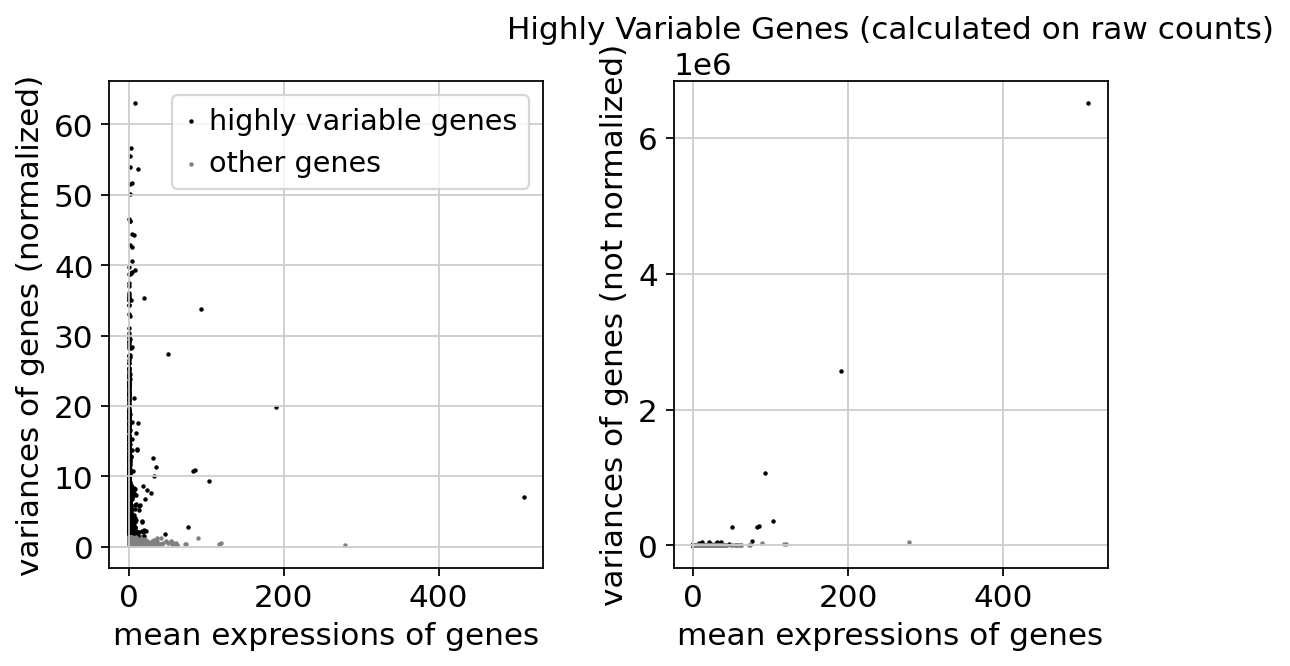

Identified 3000 highly variable genes.

--- Normalizing Total Counts ---
normalizing counts per cell
    finished (0:00:00)

--- Log-Transforming Data ---

--- Saving Log-Normalized Data to .raw ---
Log-normalized data stored in adata.raw


In [6]:
# === 3. Calculate HVGs (using Raw Counts Layer) ===
print(f"\n--- Finding Top {n_top_hvg} Highly Variable Genes (using RAW counts) ---")
sc.pp.highly_variable_genes(
    adata,
    layer='counts', # Use the raw counts stored here
    n_top_genes=n_top_hvg,
    flavor='seurat_v3',
    subset=False # Keep all genes, just add the boolean flag to adata.var
)
# This should NOT produce the "non-integers" warning now
sc.pl.highly_variable_genes(adata, show=False)
plt.title('Highly Variable Genes (calculated on raw counts)')
plt.show()
print(f"Identified {adata.var['highly_variable'].sum()} highly variable genes.")

# === 4. Normalize Total Counts ===
print("\n--- Normalizing Total Counts ---")
# Normalize based on the counts in adata.X (which are still raw at this point)
sc.pp.normalize_total(adata, target_sum=1e4) # Modifies adata.X

# === 5. Log Transform ===
print("\n--- Log-Transforming Data ---")
sc.pp.log1p(adata) # Modifies adata.X

# === 6. Save Log-Normalized State ===
# (Code remains the same)
print("\n--- Saving Log-Normalized Data to .raw ---")
adata.raw = adata.copy()
print("Log-normalized data stored in adata.raw")

In [7]:
##################saving and swithing to R for CHOIR clustering#########################
output_dir_for_r = "./choir_intermediate/" # Create a specific directory
h5ad_for_r_filename = "adata_integrated_for_choir.h5ad"
output_path_for_r = os.path.join(output_dir_for_r, h5ad_for_r_filename)

os.makedirs(output_dir_for_r, exist_ok=True)

print(f"\n--- Saving Integrated AnnData for CHOIR analysis in R ---")
print(f"Object to save: adata")
print(f"Shape: {adata.shape}")
print(f"Checking required components:")
print(f"  Batch key ('{batch_key}') in obs: {batch_key in adata.obs.columns}")


print(f"\nSaving AnnData object to: {output_path_for_r}")
try:
 # Ensure data types are compatible if possible (though write_h5ad handles most)
 adata.write(filename=output_path_for_r, compression='gzip')
 print("Successfully saved AnnData object for R.")
except Exception as e:
 print(f"ERROR: Failed to save AnnData object: {e}")


--- Saving Integrated AnnData for CHOIR analysis in R ---
Object to save: adata
Shape: (54239, 20000)
Checking required components:
  Batch key ('sample.id') in obs: True

Saving AnnData object to: ./choir_intermediate/adata_integrated_for_choir.h5ad
Successfully saved AnnData object for R.
